## Credit to Francesco Crecchi

# MNIST classification using a Convolutional Neural Network (CNN)

In [2]:
# Utility libraries
import os
import random
from datetime import datetime

# Core libraries
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax, Conv2D, MaxPooling2D, Dropout, Flatten, UpSampling2D
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from keras.utils import np_utils
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt # For plotting purposes


# Bug still not solved, resort to old keras module (see below)
# from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Use the above import when the bug is solved
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
# ------------------------------------------#

Using TensorFlow backend.


In [3]:
# Load the TensorBoard notebook extension (for visualization purposes)
%load_ext tensorboard

## Data loading

In [4]:
# Loads the training and test data sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_classes = 10

In [5]:
# We reshape the training and test data sets to be a 4D tensor.
# Dimensions: num_images x 28 x 28 x no_channels (e.g. RGB)
# The 1 is because we have a single channel (greyscale). If RGB color images, we'd have 3 channels.
# -1 means "let the library infer the dimension"
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')
input_shape = (28, 28, 1)

## Preprocess the data (scale all values between 0 and 1)

### Note: you MUST NOT use statistics coming from the TEST set. That is "cheating"!

In [6]:
# Scales the training and test data to range between 0 and 1.
max_value = X_train.max()
X_train /= max_value
X_test /= max_value

In [7]:
# The training and test labels are integers from 0 to 9 indicating the class label
(y_train, y_test)

(array([5, 0, 4, ..., 5, 6, 8], dtype=uint8),
 array([7, 2, 1, ..., 4, 5, 6], dtype=uint8))

In [8]:
# We convert the class labels to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
(y_train, y_test)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

## Define a Convolutional Neural Net (ConvNet) with the Sequential API

<img src="https://drive.google.com/uc?id=1rAe5QRDGUstZMrPirJS0hNHf3E8x_05S" width=90%>

In [25]:
model = Sequential()

# Add a convolutional layer. Outputs 10 different "filtered" images (using 10 different 5x5 kernels)
model.add(Conv2D(10, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

# Reduce the dimension of the filtered images by 2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a convolutional layer. Outputs 20 different filters (using 20 different 5x5 kernels)
model.add(Conv2D(20, (5, 5), activation='relu'))

# Reduce the dimension of the filtered images by 2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout is a technique that regularizes the model, by randomly "turning off" a percentage of the neurons
# Here, we randomly shut down 75% of the neurons at each training step
model.add(Dropout(0.25))

# Convert the Dropout output in vectorial form
model.add(Flatten())

# Apply an MLP to the vectorial representation
model.add(Dense(100, activation='relu'))

# Output class probability scores
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

# Have you noticed the number of parameters?? 40k of CNN vs 200K of an MLP!!!
## (32K only for final MLP)
## Moreover, the CNN architecture extracts *local* patches of an image, whereas an MLP combines all pixels together!

## Train Classifier (we won't do model selection today, do it as an exercise)

In [34]:
# Clear any logs from previous runs
!rm -rf ./logs_linear

# Set up a log folder in which we will store the output to be displayed on TensorBoard
logdir = os.path.abspath("logs_cnn/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir)

# Trains the model, iterating on the training data in batches of 128 in 5 epochs.
# Using the SGD optimizer.
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# We will automatically create a validation split (less flexible for model selection)
model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_split=0.25,
          callbacks=[tensorboard_callback])

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 6s 142us/sample - loss: 0.1146 - accuracy: 0.9644 - val_loss: 0.0833 - val_accuracy: 0.9745
Epoch 2/10
45000/45000 [==============================] - 6s 134us/sample - loss: 0.1110 - accuracy: 0.9653 - val_loss: 0.0807 - val_accuracy: 0.9755
Epoch 3/10
45000/45000 [==============================] - 6s 132us/sample - loss: 0.1058 - accuracy: 0.9678 - val_loss: 0.0796 - val_accuracy: 0.9755
Epoch 4/10
45000/45000 [==============================] - 6s 131us/sample - loss: 0.1019 - accuracy: 0.9688 - val_loss: 0.0764 - val_accuracy: 0.9771
Epoch 5/10
45000/45000 [==============================] - 6s 134us/sample - loss: 0.0998 - accuracy: 0.9691 - val_loss: 0.0743 - val_accuracy: 0.9783
Epoch 6/10
45000/45000 [==============================] - 6s 133us/sample - loss: 0.0962 - accuracy: 0.9699 - val_loss: 0.0731 - val_accuracy: 0.9784
Epoch 7/10
45000/45000 [==========================

In [35]:
# Visualize your model
%tensorboard --logdir {logdir}

## Model Evaluation

In [37]:
loss, acc = model.evaluate(X_test, y_test)
print("Test set accuracy: {0:.4f}".format(acc))

10000/10000 [==============================] - 1s 79us/sample - loss: 0.0549 - accuracy: 0.9829
Test set accuracy: 0.9829


---

# Using a pre-trained model

Achieving state-of-the-art image recognition performances training a neural network model from scratch is a **very hard** task. Luckly enough, there is no need to reinvent the wheel!
We can simply stand on the giant's shoulder by using some **pre-trained** deep neural network model in our application for image recognition or use it as an extremely powerful features extractor leaving us with just the duty of *specialize* this general-purpose model for our task at-hand!

Let's pretend you are working for a smart/IoT/intelligent/etc. pets feeding bowl startup and your job is to make the bowl able to recognize cats or dogs to provide the right type of food. In other words, you need to recognize a dog from a cat the most accurate as possible. How would you do that?

## Standing on the giant's shoulders!

We can _stand on the giant's shoulders_ by using a state-of-the-art convolutional model as features extractor and by _fine-tune_ the last layers to perform the _cat-vs-dog_ classification task.

We will use the _ResNet-50_ architecture, pre-trained on the ImageNet dataset. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. However, the method we present here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

Here's what the ResNet architecture looks like:

<img src="https://drive.google.com/uc?id=1AminLP0xNTlbbQ8FFKMOGRSw5oeisGqC">

Our strategy will be as follow: we will use the pre-trained convolutional part of the model as a _very_ powerful features extractor for the simple feed-forward binary classifier for distinguishing between cats and dogs images.

# Convolutional Autoencoder for Image Segmentation

![FCN](https://missinglink.ai/wp-content/uploads/2019/03/SegNet-neural-network_2x.png)

### Taken from [here](https://missinglink.ai/guides/computer-vision/image-segmentation-deep-learning-methods-applications/)

## We will use the Membrane dataset taken from [here](https://github.com/zhixuhao/unet)

Final shape of train dataset is: x -> (30, 512, 512, 1) and y -> (30, 512, 512)
Final shape of test dataset is: x -> (30, 512, 512, 1)


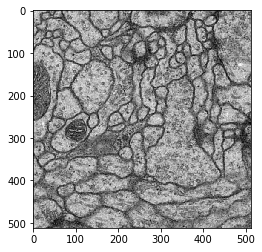

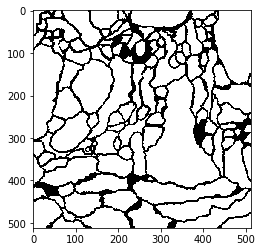

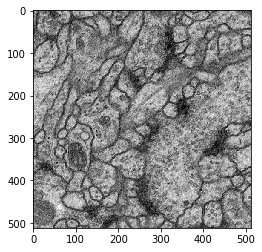

In [9]:
from matplotlib.image import imread

# Let's load all train images and put them into the right format
train_path = os.path.abspath('membrane/train/image')
train_y_path = os.path.abspath('membrane/train/label')

test_path = os.path.abspath('membrane/test/')


def build_dataset(path, y_path=None):
    
    x_data = None
    y_data = None

    for image_file in sorted([f for f in os.listdir(path) if '.png' in f]):

        x = imread(os.path.join(path, image_file))

        if y_path is not None:
            y = imread(os.path.join(y_path, image_file))

        if x_data is None:
            x_data = np.expand_dims(x, axis=(0,-1))  # add batch and channel dimensions
            if y_path is not None:
                y_data = np.expand_dims(y, axis=(0))  # add batch dimension, we do not need a channel
        else:
            x_data = np.concatenate((x_data, np.expand_dims(x, axis=(0,-1))), axis=0)
            if y_path is not None:
                y_data = np.concatenate((y_data, np.expand_dims(y, axis=(0))), axis=0)

    # Plot the last image and label
    plt.figure()
    plt.imshow(x, cmap='gray')
    if y_path is not None:
        plt.figure()
        plt.imshow(y, cmap='gray')
    
    if y_path is not None:
        y_data = y_data.astype('uint8')
    
    return x_data, y_data

x_train, y_train = build_dataset(train_path, train_y_path)
x_test, _ = build_dataset(test_path)


print(f'Final shape of train dataset is: x -> {x_train.shape} and y -> {y_train.shape}')
print(f'Final shape of test dataset is: x -> {x_test.shape}')

In [10]:
model = Sequential()

# Add a convolutional layer. Outputs 10 different "filtered" images (using 10 different 5x5 kernels)
model.add(Conv2D(20, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(512,512,1), padding="same"))

# Reduce the dimension of the filtered images by 2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a convolutional layer. Outputs 20 different filters (using 20 different 5x5 kernels)
model.add(Conv2D(30, (3, 3), activation='relu', padding="same"))

# Reduce the dimension of the filtered images by 2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a convolutional layer. Outputs 20 different filters (using 20 different 5x5 kernels)
model.add(Conv2D(30, (3, 3), activation='relu', padding="same"))

# Increase the dimension of the filtered images by 2
model.add(UpSampling2D((2, 2), interpolation='bilinear'))

# Add a convolutional layer. Outputs 20 different filters (using 20 different 5x5 kernels)
model.add(Conv2D(20, (3, 3), activation='relu', padding="same"))

# Increase the dimension of the filtered images by 2
model.add(UpSampling2D((2, 2), interpolation='bilinear'))

# Add a convolutional layer. Outputs 20 different filters (using 20 different 5x5 kernels)
model.add(Conv2D(1, (3, 3), activation='linear', padding="same"))

model.add(Flatten())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 20)      200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 30)      5430      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 30)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 30)      8130      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 256, 30)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 20)      5

In [11]:
learning_rate = 1e-3

model.compile(optimizer=optimizers.Adam(lr=learning_rate),  # Optimizer
              # Loss function to minimize
              loss=losses.BinaryCrossentropy(from_logits=False)
             )

In [12]:
# Train the Model!
# Note: fit has also the chance to specify a validation split percentage
print('# Fit model on training data')
history = model.fit(x_train, np.reshape(y_train, (-1, 512*512)),
                    batch_size=2,
                    epochs=100,
                    )

# Fit model on training data
Train on 30 samples
Epoch 1/100
30/30 [==============================] - 9s 316ms/sample - loss: 2.4186
Epoch 2/100
30/30 [==============================] - 9s 302ms/sample - loss: 0.5944
Epoch 3/100
30/30 [==============================] - 9s 317ms/sample - loss: 0.5032
Epoch 4/100
30/30 [==============================] - 9s 306ms/sample - loss: 0.4715
Epoch 5/100
30/30 [==============================] - 9s 309ms/sample - loss: 0.4752
Epoch 6/100
30/30 [==============================] - 9s 306ms/sample - loss: 0.4965
Epoch 7/100
30/30 [==============================] - 9s 299ms/sample - loss: 0.4567
Epoch 8/100
30/30 [==============================] - 9s 300ms/sample - loss: 0.4534
Epoch 9/100
30/30 [==============================] - 9s 299ms/sample - loss: 0.4583
Epoch 10/100
30/30 [==============================] - 9s 300ms/sample - loss: 0.4429
Epoch 11/100
30/30 [==============================] - 9s 299ms/sample - loss: 0.4380
Epoch 12/100
30/30 [=====

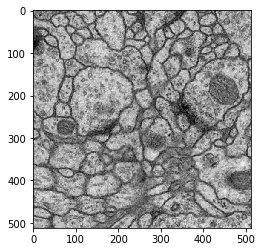

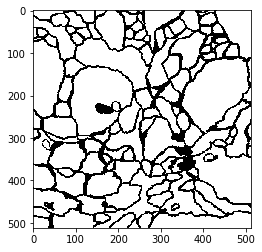

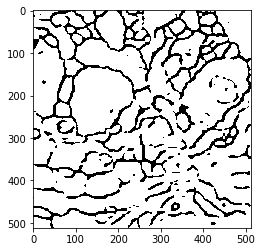

In [16]:
pred_train = np.reshape(model.predict(x_train), (-1, 512,512))
plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray')
plt.figure()
plt.imshow(y_train[0], cmap='gray')
plt.figure()
plt.imshow(np.round(pred_train[0]), cmap='gray')

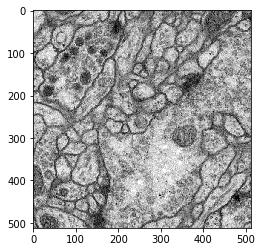

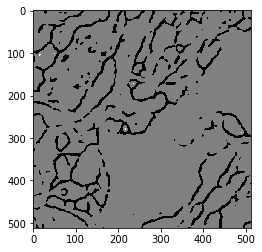

In [15]:
pred_test = np.reshape(model.predict(x_test), (-1, 512,512))
plt.figure()
plt.imshow(x_test[0, :, :, 0], cmap='gray')
plt.figure()
plt.imshow(pred_test[0], cmap='gray')

# Exercise: Convolutional Auto-Encoders for Anomaly Detection
## You can reuse today's fully convolutional net and yesterday anomaly detection code to perform anomaly detection with convolutional nets!